# Method 2 - Best Ideas

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data.groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

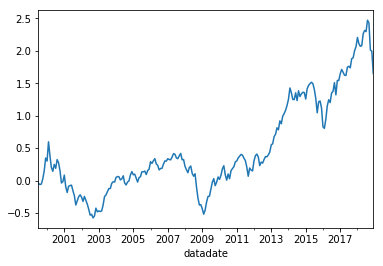

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.347086
2000-12-31   -0.269533
2001-12-31   -0.206918
2002-12-31   -0.336016
2003-12-31    0.886725
2004-12-31    0.163801
2005-12-31    0.034594
2006-12-31    0.104108
2007-12-31    0.018646
2008-12-31   -0.524858
2009-12-31    0.677779
2010-12-31    0.221162
2011-12-31   -0.108812
2012-12-31    0.253494
2013-12-31    0.498781
2014-12-31    0.091865
2015-12-31   -0.100057
2016-12-31    0.198698
2017-12-31    0.204971
2018-12-31   -0.134930
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     537.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.55e-115
Time:                        03:09:38   Log-Likelihood:                 547.62
No. Observations:                 234   AIC:                            -1085.
Df Residuals:                     229   BIC:                            -1068.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      2.113      0.036       0.000       0.007
mktrf          1.1039      0.044     25.127      0.000       1.017       1.190
me             0.5142      0.051     10.062      0.000       0.414       0.615
ia            -0.1327      0.078     -1.709      0.089      -0.286       0.020
roe           -0.7030      0.066    -10.574      0.000      -0.834      -0.572
==============================================================================
Omnibus:                       45.708   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.305
Skew:                           0.768   Prob(JB):                     3.11e-34
Kurtosis:                       6.670   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     363.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.86e-98
Time:                        03:09:38   Log-Likelihood:                 547.62
No. Observations:                 234   AIC:                            -1085.
Df Residuals:                     229   BIC:                            -1068.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.804      0.071      -0.000       0.007
mktrf          1.1039      0.045     24.776      0.000       1.017       1.191
me             0.5142      0.059      8.664      0.000       0.398       0.631
ia            -0.1327      0.125     -1.058      0.290      -0.379       0.113
roe           -0.7030      0.134     -5.232      0.000      -0.966      -0.440
==============================================================================
Omnibus:                       45.708   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.305
Skew:                           0.768   Prob(JB):                     3.11e-34
Kurtosis:                       6.670   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     543.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.42e-115
Time:                        03:09:38   Log-Likelihood:                 547.62
No. Observations:                 234   AIC:                            -1085.
Df Residuals:                     229   BIC:                            -1068.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.883      0.060      -0.000       0.007
mktrf          1.1039      0.037     29.715      0.000       1.031       1.177
me             0.5142      0.061      8.364      0.000       0.394       0.635
ia            -0.1327      0.106     -1.254      0.210      -0.340       0.075
roe           -0.7030      0.142     -4.945      0.000      -0.982      -0.424
==============================================================================
Omnibus:                       45.708   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.305
Skew:                           0.768   Prob(JB):                     3.11e-34
Kurtosis:                       6.670   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     410.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.93e-112
Time:                        03:09:38   Log-Likelihood:                 543.24
No. Observations:                 234   AIC:                            -1074.
Df Residuals:                     228   BIC:                            -1054.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.872      0.063      -0.000       0.006
mktrf          1.1723      0.045     26.080      0.000       1.084       1.261
smb            0.4983      0.059      8.402      0.000       0.381       0.615
hml            0.0013      0.070      0.019      0.985      -0.136       0.139
rmw           -0.7143      0.079     -9.034      0.000      -0.870      -0.559
cma            0.0728      0.101      0.724      0.470      -0.125       0.271
==============================================================================
Omnibus:                       36.436   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.032
Skew:                           0.727   Prob(JB):                     5.66e-19
Kurtosis:                       5.551   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     221.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.51e-85
Time:                        03:09:38   Log-Likelihood:                 543.24
No. Observations:                 234   AIC:                            -1074.
Df Residuals:                     228   BIC:                            -1054.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.805      0.071      -0.000       0.006
mktrf          1.1723      0.044     26.884      0.000       1.087       1.258
smb            0.4983      0.048     10.461      0.000       0.405       0.592
hml            0.0013      0.111      0.012      0.990      -0.216       0.218
rmw           -0.7143      0.130     -5.503      0.000      -0.969      -0.460
cma            0.0728      0.145      0.503      0.615      -0.211       0.356
==============================================================================
Omnibus:                       36.436   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.032
Skew:                           0.727   Prob(JB):                     5.66e-19
Kurtosis:                       5.551   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     237.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.56e-88
Time:                        03:09:38   Log-Likelihood:                 543.24
No. Observations:                 234   AIC:                            -1074.
Df Residuals:                     228   BIC:                            -1054.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.971      0.049    1.73e-05       0.006
mktrf          1.1723      0.047     25.204      0.000       1.081       1.263
smb            0.4983      0.047     10.616      0.000       0.406       0.590
hml            0.0013      0.086      0.016      0.987      -0.166       0.169
rmw           -0.7143      0.135     -5.291      0.000      -0.979      -0.450
cma            0.0728      0.123      0.594      0.553      -0.168       0.313
==============================================================================
Omnibus:                       36.436   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.032
Skew:                           0.727   Prob(JB):                     5.66e-19
Kurtosis:                       5.551   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     403.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.00e-102
Time:                        03:09:38   Log-Likelihood:                 517.84
No. Observations:                 234   AIC:                            -1026.
Df Residuals:                     229   BIC:                            -1008.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.357      0.722      -0.003       0.004
mktrf          1.2633      0.046     27.499      0.000       1.173       1.354
smb            0.7817      0.057     13.632      0.000       0.669       0.895
hml           -0.1116      0.057     -1.959      0.051      -0.224       0.001
umd           -0.1829      0.037     -4.893      0.000      -0.257      -0.109
==============================================================================
Omnibus:                       50.927   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.741
Skew:                           0.912   Prob(JB):                     1.12e-33
Kurtosis:                       6.498   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     249.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.85e-82
Time:                        03:09:38   Log-Likelihood:                 517.84
No. Observations:                 234   AIC:                            -1026.
Df Residuals:                     229   BIC:                            -1008.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.356      0.722      -0.003       0.004
mktrf          1.2633      0.049     26.000      0.000       1.168       1.359
smb            0.7817      0.080      9.765      0.000       0.625       0.939
hml           -0.1116      0.084     -1.332      0.183      -0.276       0.053
umd           -0.1829      0.071     -2.591      0.010      -0.321      -0.045
==============================================================================
Omnibus:                       50.927   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.741
Skew:                           0.912   Prob(JB):                     1.12e-33
Kurtosis:                       6.498   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     239.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.44e-80
Time:                        03:09:38   Log-Likelihood:                 517.84
No. Observations:                 234   AIC:                            -1026.
Df Residuals:                     229   BIC:                            -1008.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.401      0.689      -0.002       0.004
mktrf          1.2633      0.048     26.438      0.000       1.170       1.357
smb            0.7817      0.072     10.895      0.000       0.641       0.922
hml           -0.1116      0.072     -1.540      0.124      -0.254       0.030
umd           -0.1829      0.073     -2.496      0.013      -0.326      -0.039
==============================================================================
Omnibus:                       50.927   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.741
Skew:                           0.912   Prob(JB):                     1.12e-33
Kurtosis:                       6.498   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     259.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.40e-56
Time:                        03:09:38   Log-Likelihood:                 259.24
No. Observations:                 120   AIC:                            -508.5
Df Residuals:                     115   BIC:                            -494.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.409      0.161      -0.002       0.009
mktrf          1.1409      0.073     15.533      0.000       0.995       1.286
me             0.5229      0.073      7.208      0.000       0.379       0.667
ia            -0.1411      0.114     -1.242      0.217      -0.366       0.084
roe           -0.6373      0.101     -6.338      0.000      -0.836      -0.438
==============================================================================
Omnibus:                       24.986   Durbin-Watson:                   2.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.821
Skew:                           0.762   Prob(JB):                     2.28e-14
Kurtosis:                       6.201   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     171.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.62e-47
Time:                        03:09:38   Log-Likelihood:                 259.24
No. Observations:                 120   AIC:                            -508.5
Df Residuals:                     115   BIC:                            -494.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.127      0.260      -0.003       0.011
mktrf          1.1409      0.076     15.059      0.000       0.992       1.289
me             0.5229      0.088      5.952      0.000       0.351       0.695
ia            -0.1411      0.182     -0.775      0.438      -0.498       0.216
roe           -0.6373      0.190     -3.360      0.001      -1.009      -0.266
==============================================================================
Omnibus:                       24.986   Durbin-Watson:                   2.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.821
Skew:                           0.762   Prob(JB):                     2.28e-14
Kurtosis:                       6.201   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     258.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.80e-56
Time:                        03:09:38   Log-Likelihood:                 259.24
No. Observations:                 120   AIC:                            -508.5
Df Residuals:                     115   BIC:                            -494.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.003      1.182      0.237      -0.003       0.010
mktrf          1.1409      0.064     17.922      0.000       1.016       1.266
me             0.5229      0.092      5.704      0.000       0.343       0.703
ia            -0.1411      0.163     -0.867      0.386      -0.460       0.178
roe           -0.6373      0.199     -3.210      0.001      -1.026      -0.248
==============================================================================
Omnibus:                       24.986   Durbin-Watson:                   2.148
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.821
Skew:                           0.762   Prob(JB):                     2.28e-14
Kurtosis:                       6.201   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     228.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.28e-57
Time:                        03:09:38   Log-Likelihood:                 264.77
No. Observations:                 120   AIC:                            -517.5
Df Residuals:                     114   BIC:                            -500.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.003      2.004      0.047    6.11e-05       0.011
mktrf          1.2532      0.074     16.870      0.000       1.106       1.400
smb            0.4953      0.084      5.887      0.000       0.329       0.662
hml           -0.0699      0.103     -0.678      0.499      -0.274       0.134
rmw           -0.6375      0.122     -5.243      0.000      -0.878      -0.397
cma            0.1608      0.133      1.207      0.230      -0.103       0.425
==============================================================================
Omnibus:                       16.789   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.395
Skew:                           0.647   Prob(JB):                     1.13e-06
Kurtosis:                       4.951   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     147.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.03e-48
Time:                        03:09:38   Log-Likelihood:                 264.77
No. Observations:                 120   AIC:                            -517.5
Df Residuals:                     114   BIC:                            -500.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.003      1.994      0.046    9.06e-05       0.011
mktrf          1.2532      0.066     18.886      0.000       1.123       1.383
smb            0.4953      0.068      7.273      0.000       0.362       0.629
hml           -0.0699      0.146     -0.478      0.633      -0.356       0.216
rmw           -0.6375      0.181     -3.520      0.000      -0.992      -0.283
cma            0.1608      0.162      0.995      0.320      -0.156       0.478
==============================================================================
Omnibus:                       16.789   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.395
Skew:                           0.647   Prob(JB):                     1.13e-06
Kurtosis:                       4.951   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     208.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.28e-55
Time:                        03:09:38   Log-Likelihood:                 264.77
No. Observations:                 120   AIC:                            -517.5
Df Residuals:                     114   BIC:                            -500.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      0.002      2.176      0.030       0.001       0.010
mktrf          1.2532      0.061     20.429      0.000       1.133       1.373
smb            0.4953      0.067      7.441      0.000       0.365       0.626
hml           -0.0699      0.124     -0.561      0.575      -0.314       0.174
rmw           -0.6375      0.193     -3.310      0.001      -1.015      -0.260
cma            0.1608      0.122      1.312      0.189      -0.079       0.401
==============================================================================
Omnibus:                       16.789   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.395
Skew:                           0.647   Prob(JB):                     1.13e-06
Kurtosis:                       4.951   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     229.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.31e-54
Time:                        03:09:38   Log-Likelihood:                 252.70
No. Observations:                 120   AIC:                            -495.4
Df Residuals:                     115   BIC:                            -481.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.003      0.917      0.361      -0.003       0.008
mktrf          1.3524      0.068     19.792      0.000       1.217       1.488
smb            0.7658      0.078      9.843      0.000       0.612       0.920
hml           -0.1472      0.078     -1.889      0.061      -0.302       0.007
umd           -0.1456      0.048     -3.032      0.003      -0.241      -0.050
==============================================================================
Omnibus:                       27.061   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.410
Skew:                           0.819   Prob(JB):                     5.14e-16
Kurtosis:                       6.376   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     194.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.56e-50
Time:                        03:09:38   Log-Likelihood:                 252.70
No. Observations:                 120   AIC:                            -495.4
Df Residuals:                     115   BIC:                            -481.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.003      0.920      0.358      -0.003       0.008
mktrf          1.3524      0.060     22.493      0.000       1.235       1.470
smb            0.7658      0.099      7.700      0.000       0.571       0.961
hml           -0.1472      0.099     -1.481      0.139      -0.342       0.048
umd           -0.1456      0.078     -1.878      0.060      -0.298       0.006
==============================================================================
Omnibus:                       27.061   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.410
Skew:                           0.819   Prob(JB):                     5.14e-16
Kurtosis:                       6.376   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     291.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.55e-59
Time:                        03:09:38   Log-Likelihood:                 252.70
No. Observations:                 120   AIC:                            -495.4
Df Residuals:                     115   BIC:                            -481.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.072      0.284      -0.002       0.007
mktrf          1.3524      0.047     28.830      0.000       1.260       1.444
smb            0.7658      0.093      8.257      0.000       0.584       0.948
hml           -0.1472      0.090     -1.638      0.101      -0.323       0.029
umd           -0.1456      0.075     -1.929      0.054      -0.294       0.002
==============================================================================
Omnibus:                       27.061   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.410
Skew:                           0.819   Prob(JB):                     5.14e-16
Kurtosis:                       6.376   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     289.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.80e-57
Time:                        03:09:38   Log-Likelihood:                 303.80
No. Observations:                 114   AIC:                            -597.6
Df Residuals:                     109   BIC:                            -583.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.002      1.868      0.064      -0.000       0.007
mktrf          1.0784      0.051     21.294      0.000       0.978       1.179
me             0.4898      0.078      6.265      0.000       0.335       0.645
ia            -0.1653      0.108     -1.524      0.130      -0.380       0.050
roe           -0.8622      0.095     -9.048      0.000      -1.051      -0.673
==============================================================================
Omnibus:                       15.470   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.160
Skew:                           0.696   Prob(JB):                     2.54e-05
Kurtosis:                       4.586   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     570.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.12e-72
Time:                        03:09:38   Log-Likelihood:                 303.80
No. Observations:                 114   AIC:                            -597.6
Df Residuals:                     109   BIC:                            -583.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.504      0.012       0.001       0.006
mktrf          1.0784      0.044     24.357      0.000       0.992       1.165
me             0.4898      0.040     12.369      0.000       0.412       0.567
ia            -0.1653      0.107     -1.544      0.123      -0.375       0.045
roe           -0.8622      0.112     -7.708      0.000      -1.081      -0.643
==============================================================================
Omnibus:                       15.470   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.160
Skew:                           0.696   Prob(JB):                     2.54e-05
Kurtosis:                       4.586   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     916.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.66e-83
Time:                        03:09:38   Log-Likelihood:                 303.80
No. Observations:                 114   AIC:                            -597.6
Df Residuals:                     109   BIC:                            -583.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0032      0.001      2.684      0.007       0.001       0.006
mktrf          1.0784      0.035     30.739      0.000       1.010       1.147
me             0.4898      0.033     14.792      0.000       0.425       0.555
ia            -0.1653      0.105     -1.573      0.116      -0.371       0.041
roe           -0.8622      0.097     -8.924      0.000      -1.052      -0.673
==============================================================================
Omnibus:                       15.470   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.160
Skew:                           0.696   Prob(JB):                     2.54e-05
Kurtosis:                       4.586   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     165.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.62e-49
Time:                        03:09:38   Log-Likelihood:                 287.20
No. Observations:                 114   AIC:                            -562.4
Df Residuals:                     108   BIC:                            -546.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.589      0.557      -0.003       0.005
mktrf          1.1200      0.056     19.956      0.000       1.009       1.231
smb            0.5057      0.091      5.550      0.000       0.325       0.686
hml            0.0649      0.116      0.558      0.578      -0.165       0.295
rmw           -0.8041      0.142     -5.651      0.000      -1.086      -0.522
cma           -0.0856      0.181     -0.474      0.637      -0.444       0.272
==============================================================================
Omnibus:                        7.248   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                7.405
Skew:                           0.450   Prob(JB):                       0.0247
Kurtosis:                       3.866   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     192.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.87e-52
Time:                        03:09:38   Log-Likelihood:                 287.20
No. Observations:                 114   AIC:                            -562.4
Df Residuals:                     108   BIC:                            -546.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.655      0.513      -0.002       0.005
mktrf          1.1200      0.057     19.515      0.000       1.008       1.233
smb            0.5057      0.065      7.747      0.000       0.378       0.634
hml            0.0649      0.144      0.452      0.651      -0.217       0.346
rmw           -0.8041      0.220     -3.661      0.000      -1.235      -0.374
cma           -0.0856      0.173     -0.495      0.621      -0.425       0.254
==============================================================================
Omnibus:                        7.248   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                7.405
Skew:                           0.450   Prob(JB):                       0.0247
Kurtosis:                       3.866   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     325.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.22e-63
Time:                        03:09:38   Log-Likelihood:                 287.20
No. Observations:                 114   AIC:                            -562.4
Df Residuals:                     108   BIC:                            -546.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.781      0.435      -0.002       0.004
mktrf          1.1200      0.057     19.508      0.000       1.008       1.233
smb            0.5057      0.060      8.389      0.000       0.388       0.624
hml            0.0649      0.153      0.425      0.671      -0.234       0.364
rmw           -0.8041      0.209     -3.849      0.000      -1.214      -0.395
cma           -0.0856      0.192     -0.446      0.655      -0.462       0.290
==============================================================================
Omnibus:                        7.248   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                7.405
Skew:                           0.450   Prob(JB):                       0.0247
Kurtosis:                       3.866   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     167.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.31e-45
Time:                        03:09:38   Log-Likelihood:                 276.19
No. Observations:                 114   AIC:                            -542.4
Df Residuals:                     109   BIC:                            -528.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.124      0.902      -0.004       0.005
mktrf          1.1532      0.061     18.861      0.000       1.032       1.274
smb            0.6959      0.095      7.300      0.000       0.507       0.885
hml            0.0583      0.098      0.593      0.554      -0.136       0.253
umd           -0.2256      0.074     -3.046      0.003      -0.372      -0.079
==============================================================================
Omnibus:                       20.696   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.575
Skew:                           0.797   Prob(JB):                     1.88e-08
Kurtosis:                       5.225   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     183.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.71e-47
Time:                        03:09:38   Log-Likelihood:                 276.19
No. Observations:                 114   AIC:                            -542.4
Df Residuals:                     109   BIC:                            -528.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.002      0.166      0.868      -0.003       0.003
mktrf          1.1532      0.060     19.240      0.000       1.036       1.271
smb            0.6959      0.080      8.649      0.000       0.538       0.854
hml            0.0583      0.160      0.364      0.716      -0.256       0.372
umd           -0.2256      0.077     -2.921      0.003      -0.377      -0.074
==============================================================================
Omnibus:                       20.696   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.575
Skew:                           0.797   Prob(JB):                     1.88e-08
Kurtosis:                       5.225   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     198.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.28e-49
Time:                        03:09:38   Log-Likelihood:                 276.19
No. Observations:                 114   AIC:                            -542.4
Df Residuals:                     109   BIC:                            -528.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.183      0.855      -0.003       0.003
mktrf          1.1532      0.057     20.348      0.000       1.042       1.264
smb            0.6959      0.062     11.251      0.000       0.575       0.817
hml            0.0583      0.167      0.348      0.727      -0.269       0.386
umd           -0.2256      0.073     -3.103      0.002      -0.368      -0.083
==============================================================================
Omnibus:                       20.696   Durbin-Watson:                   1.768
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.575
Skew:                           0.797   Prob(JB):                     1.88e-08
Kurtosis:                       5.225   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""